---
date: last-modified
---

# Demonstration for working with TEMPO data via `Harmony-py`

## Overview

This notebook demonstrates how to retrieve and visualize TEMPO data, using `harmony-py` to subset the data in the cloud, prior to downloading files.

### Prerequisites

A free(!) account at https://www.earthdata.nasa.gov/ is needed to login and download the appropriate files.

This notebook was last tested using Python 3.10.15, and requires these libraries:

- [cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [harmony-py](https://github.com/nasa/harmony-py)
- [matplotlib](http://matplotlib.org/)
- [numpy](https://numpy.org/)
- [xarray](https://github.com/pydata/xarray)

### Notebook Author / Affiliation
- Author: Daniel Kaufman / Atmospheric Science Data Center
- Created: 3 May 2023
- This notebook is based on examples from the [harmony-py repository](https://github.com/nasa/harmony-py/tree/main/examples) and https://harmony.earthdata.nasa.gov/docs.

## What is Harmony?
Harmony is the **cloud services orchestrator** for [NASA Earth Science Data and Information System (ESDIS)](https://www.earthdata.nasa.gov/esdis). The goal of Harmony is to provide services to increase usage and ease of use of ESDIS' Earth observation data, especially focusing on opportunities made possible by cloud-accessible data. 

Data processed by Harmony are staged in Amazon s3 buckets, and Harmony services run in containers in pods in a Kubernetes cluster.

Note that services provided via Harmony **can transform NASA data as well as provide access to the original data**, through an Application Programmable Interface (API)...

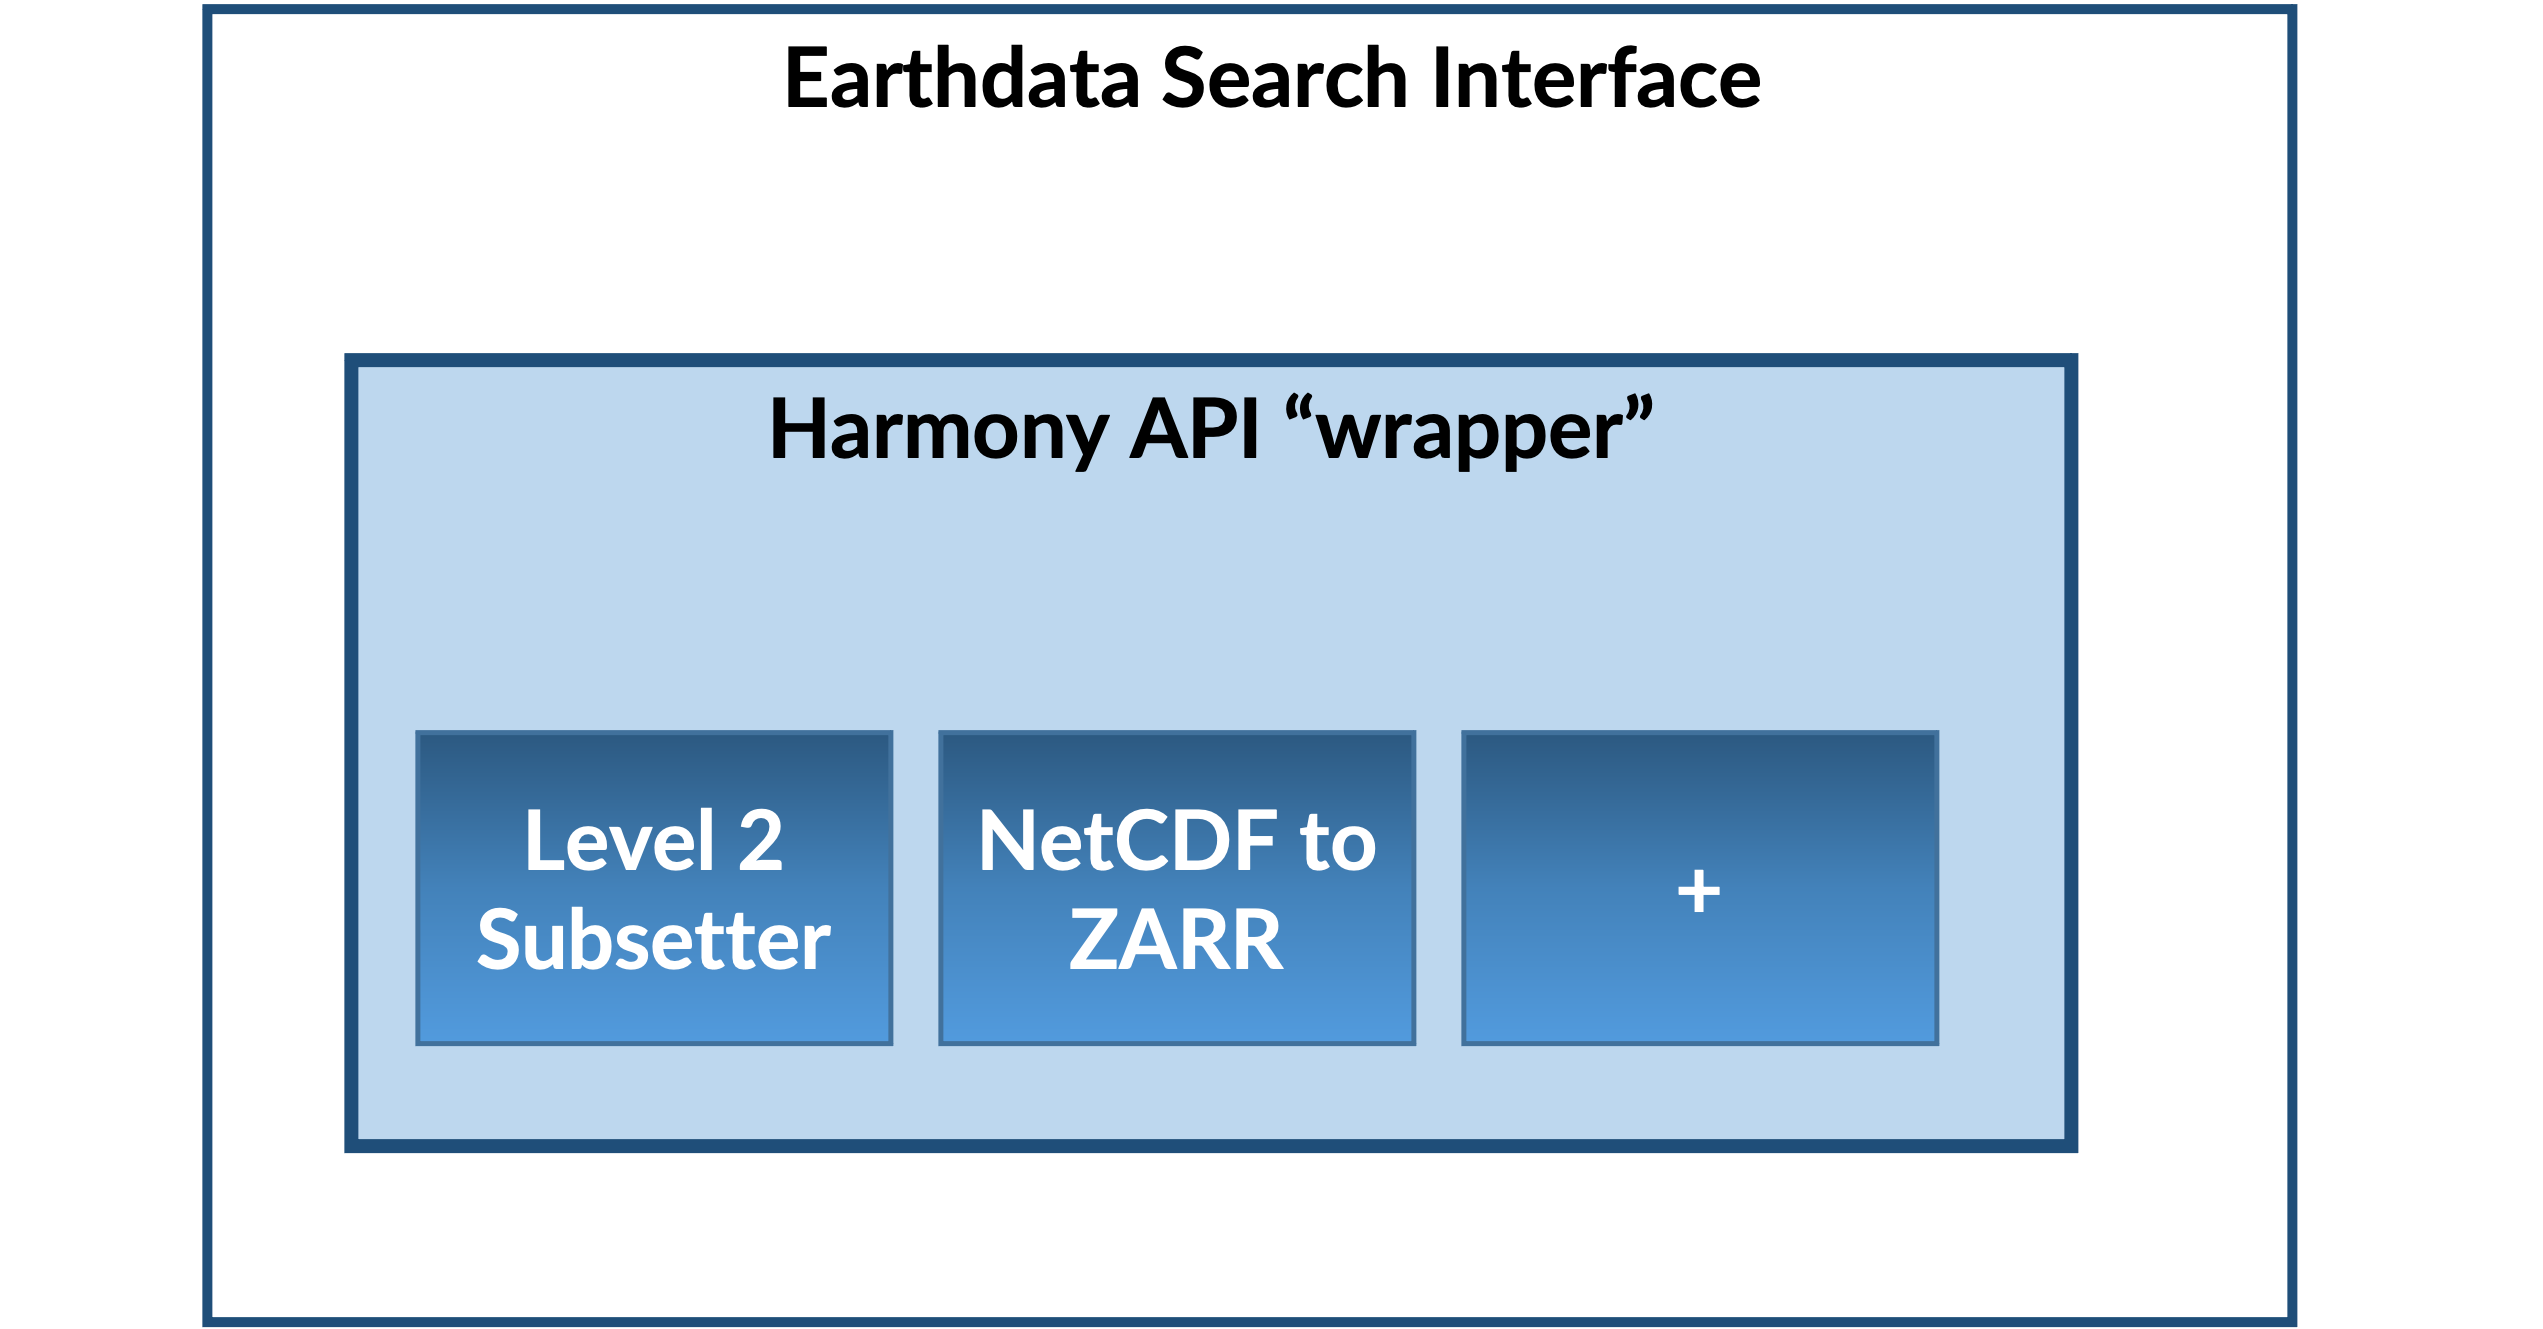

Harmony services **can be invoked through curl commands**, e.g.:

> https://harmony.earthdata.nasa.gov/{collectionId}/ogc-api-coverages/1.0.0/{variable}/coverage/rangeset

(Harmony services REST API conforms to the OGC Coverages API version 1.0.0. It accepts parameters in the URL path as well as query parameters.)


Harmony **can also be invoked via wrapper libraries such as `harmony-py`**, which is demonstrated below.

In [2]:
!pip install -U harmony-py

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for curlify: filename=curlify-2.2.1-py3-none-any.whl size=2667 sha256=af509e7863b49671c11b707d092a76a456887ee742302fd745067e9577fca5da
  Stored in directory: /root/.cache/pip/wheels/e1/6b/61/f8560ac125bd64f2b87b9af2f9ae08f8dbaec154f583a9e301
Successfully built curlify
  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 4.5.0
    Uninstalling progressbar2-4.5.0:
      Successfully uninstalled progressbar2-4.5.0
  Attempting uninstall: shapely
    Found existing installation: shapely 2.1.1
    Uninstalling shapely-2.1.1:
      Successfully uninstalled shapely-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is n

## 1. Setup

In [3]:
# Load packages into current runtime
import datetime as dt
import getpass

import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray.plot.utils import label_from_attrs

from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

## 2. Retrieve a data file (via Harmony)

All users will need an Earthdata Login (EDL) account in order to access NASA data and services. 

Once a user has an EDL username and password they will need to use these when accessing Harmony.

In [4]:
print("Please provide your Earthdata Login credentials to allow data access")
print("Your credentials will only be passed to Earthdata and will not be exposed in the notebook")
username = input("Username:")

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

Please provide your Earthdata Login credentials to allow data access
Your credentials will only be passed to Earthdata and will not be exposed in the notebook


Username: asaadzx
 ········


Choose a granule, and write out the request with a chosen *collection* ID and *granule* name.

In this case, we'll choose a granule (a ~6 minute window) containing nitrogen dioxide data crossing part of the Rocky Mountain region of the U.S.

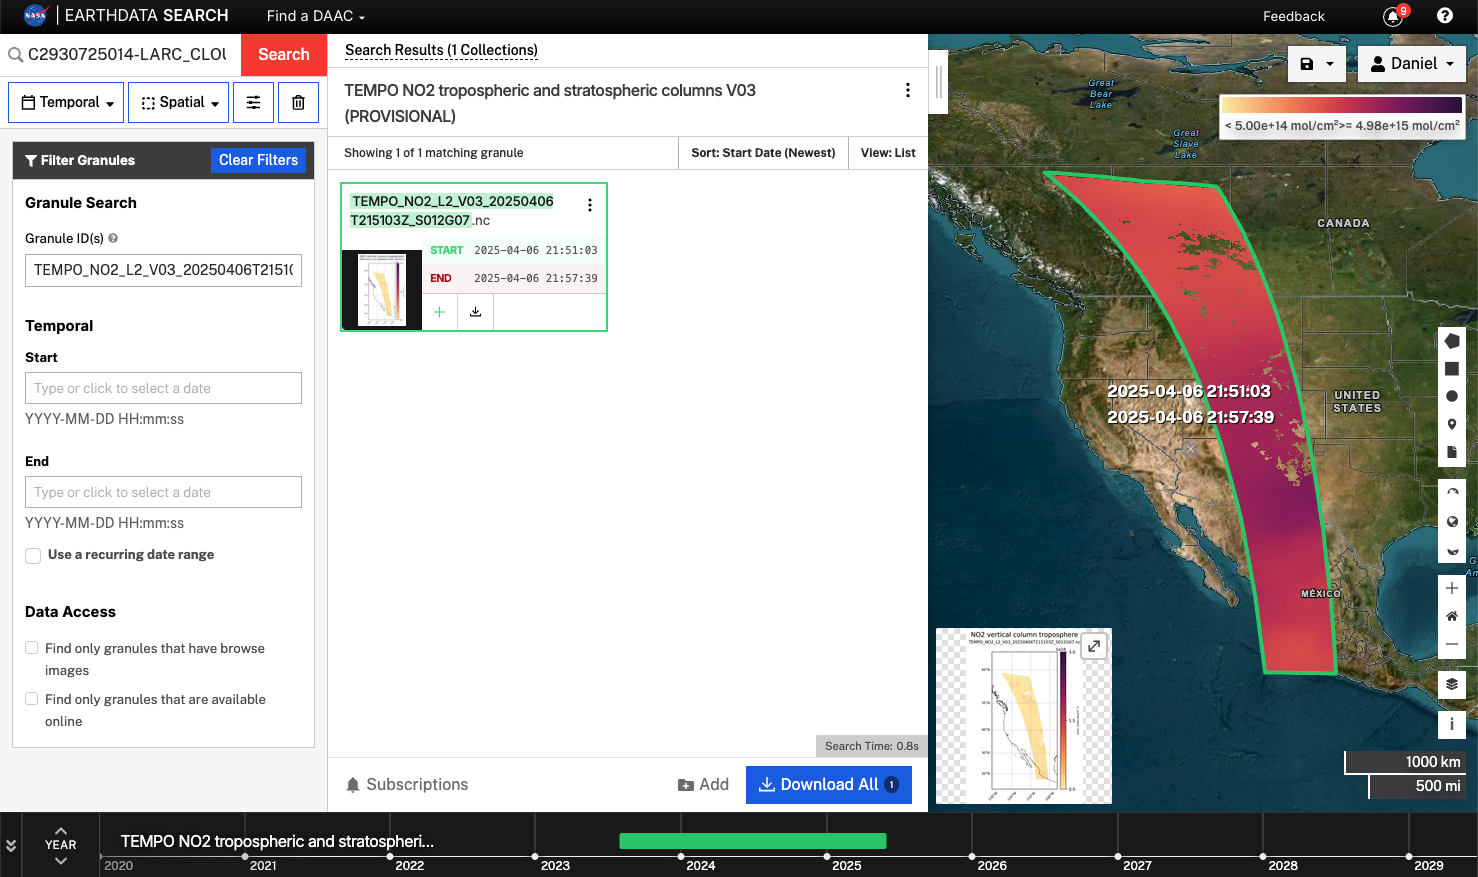

**A Collection ID is needed**

How do we get one?
Search for collection short name, TEMPO_NO2_L2, in EarthData https://search.earthdata.nasa.gov/search
and select the version, and find collection_ID in the address line.

In [5]:
# "Nitrogen Dioxide total column"
request = Request(
    collection=Collection(id="C2930725014-LARC_CLOUD"),
    granule_name=["TEMPO_NO2_L2_V03_20250406T215103Z_S012G07.nc"],
)
request.is_valid()

True

Submit the request, and then wait for the processing to complete.

In [6]:
job_id = harmony_client.submit(request)
print(f"jobID = {job_id}")

harmony_client.wait_for_processing(job_id, show_progress=True)

jobID = 34b68146-303a-425c-86e9-1eb60e43d8fe


 [ Processing: 100% ] |###################################################| [|]


Download the resulting files

In [7]:
results = harmony_client.download_all(job_id, directory="/tmp")
all_results_stored = [f.result() for f in results]

print(f"Number of result files: {len(all_results_stored)}")

/tmp/TEMPO_NO2_L2_V03_20250406T215103Z_S012G07.nc
Number of result files: 1


## 3. Open the data file

In [8]:
# Open the data file using the Xarray package.
#   Alternatively, one could use the
#   netCDF4-python (https://unidata.github.io/netcdf4-python/) library.
datatree = xr.open_datatree(all_results_stored[0])
datatree

<xarray.DataTree>
Group: /
│   Dimensions:      (xtrack: 2048, mirror_step: 131)
│   Coordinates:
│     * xtrack       (xtrack) int32 8kB 0 1 2 3 4 5 ... 2043 2044 2045 2046 2047
│     * mirror_step  (mirror_step) int32 524B 788 789 790 791 ... 915 916 917 918
│   Attributes: (12/38)
│       tio_commit:                       bd5e3a3bec43c1970873e2537a09576f5e1d10df
│       product_type:                     NO2
│       processing_level:                 2
│       processing_version:               3
│       sdpc_version:                     TEMPO_SDPC_v4.4.3
│       scan_num:                         12
│       ...                               ...
│       collection_shortname:             TEMPO_NO2_L2
│       collection_version:               1
│       keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>NI...
│       summary:                          Nitrogen dioxide Level 2 files provide ...
│       coremetadata:                     \nGROUP                  = INVENTORYMET...
│       history:                          2025-04-07T02:04:27Z:/tempo/nas0/sdpc_s...
├── Group: /product
│       Dimensions:                                  (mirror_step: 131, xtrack: 2048)
│       Data variables:
│           main_data_quality_flag                   (mirror_step, xtrack) float32 1MB ...
│           vertical_column_troposphere              (mirror_step, xtrack) float64 2MB ...
│           vertical_column_stratosphere             (mirror_step, xtrack) float64 2MB ...
│           vertical_column_troposphere_uncertainty  (mirror_step, xtrack) float64 2MB ...
├── Group: /geolocation
│       Dimensions:                 (mirror_step: 131, xtrack: 2048, corner: 4)
│       Coordinates:
│           time                    (mirror_step) datetime64[ns] 1kB ...
│           latitude                (mirror_step, xtrack) float32 1MB ...
│           longitude               (mirror_step, xtrack) float32 1MB ...
│       Dimensions without coordinates: corner
│       Data variables:
│           latitude_bounds         (mirror_step, xtrack, corner) float32 4MB ...
│           longitude_bounds        (mirror_step, xtrack, corner) float32 4MB ...
│           solar_zenith_angle      (mirror_step, xtrack) float32 1MB ...
│           solar_azimuth_angle     (mirror_step, xtrack) float32 1MB ...
│           viewing_zenith_angle    (mirror_step, xtrack) float32 1MB ...
│           viewing_azimuth_angle   (mirror_step, xtrack) float32 1MB ...
│           relative_azimuth_angle  (mirror_step, xtrack) float32 1MB ...
├── Group: /support_data
│       Dimensions:                            (mirror_step: 131, xtrack: 2048,
│                                               swt_level: 72)
│       Dimensions without coordinates: swt_level
│       Data variables: (12/20)
│           vertical_column_total              (mirror_step, xtrack) float64 2MB ...
│           vertical_column_total_uncertainty  (mirror_step, xtrack) float64 2MB ...
│           fitted_slant_column                (mirror_step, xtrack) float64 2MB ...
│           fitted_slant_column_uncertainty    (mirror_step, xtrack) float64 2MB ...
│           snow_ice_fraction                  (mirror_step, xtrack) float32 1MB ...
│           terrain_height                     (mirror_step, xtrack) float32 1MB ...
│           ...                                 ...
│           amf_diagnostic_flag                (mirror_step, xtrack) float32 1MB ...
│           eff_cloud_fraction                 (mirror_step, xtrack) float32 1MB ...
│           amf_cloud_fraction                 (mirror_step, xtrack) float32 1MB ...
│           amf_cloud_pressure                 (mirror_step, xtrack) float32 1MB ...
│           amf_troposphere                    (mirror_step, xtrack) float32 1MB ...
│           amf_stratosphere                   (mirror_step, xtrack) float32 1MB ...
└── Group: /qa_statistics
        Dimensions:               (mirror_step: 131, xtrack: 2048)
        Data variables:
            fit_rms_resi

## 4. Visualize one of the data variables

### Map

Here we take a look at the Vertical Column Troposphere variable, both its metadata and then by creating a map visualization. Note the use of `main_data_quality_flag` in the plotting code to ensure that we are examining only the "normal" quality data.

In [9]:
product_variable_name = "product/vertical_column_troposphere"
da = datatree[product_variable_name]
da

<xarray.DataArray 'vertical_column_troposphere' (mirror_step: 131, xtrack: 2048)> Size: 2MB
[268288 values with dtype=float64]
Coordinates:
  * xtrack       (xtrack) int32 8kB 0 1 2 3 4 5 ... 2043 2044 2045 2046 2047
  * mirror_step  (mirror_step) int32 524B 788 789 790 791 ... 915 916 917 918
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

In [10]:
data_proj = ccrs.PlateCarree()


def make_nice_map(axis):
    axis.add_feature(cfeature.STATES, color="gray", lw=0.1)
    axis.coastlines(resolution="50m", color="gray", linewidth=0.5)

    axis.set_extent([-150, -40, 14, 65], crs=data_proj)
    grid = axis.gridlines(draw_labels=["left", "bottom"], dms=True)
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


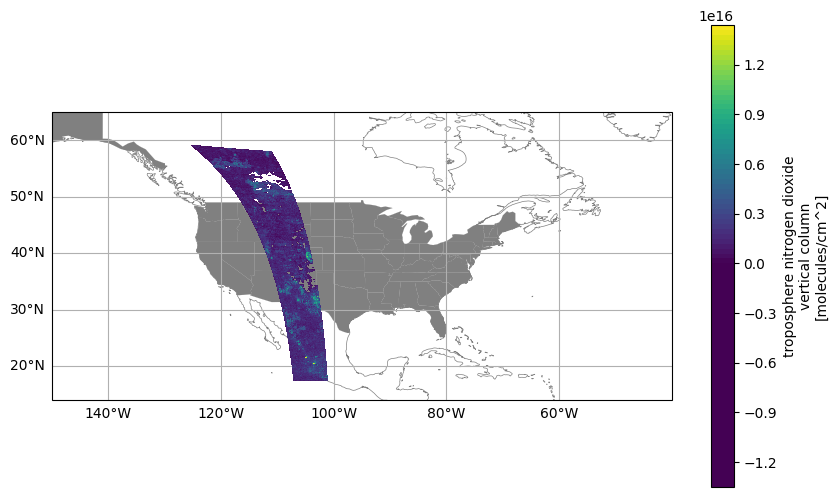

In [11]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

contour_handle = ax.contourf(
    datatree["geolocation/longitude"],
    datatree["geolocation/latitude"],
    da.where(datatree["product/main_data_quality_flag"] == 0),
    levels=100,
    vmin=0,
    zorder=2,
)

cb = plt.colorbar(contour_handle)
cb.set_label(label_from_attrs(da))

plt.show()

### Zonal means

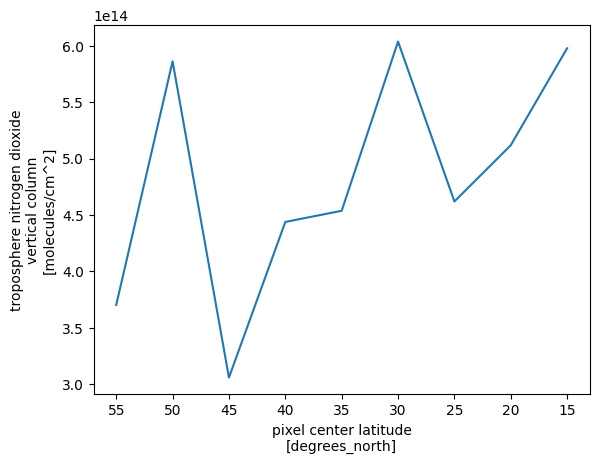

In [12]:
# Define two-degree wide latitude bins.
lat_bins = np.arange(15, 61, 5)

# Define a label for each bin corresponding to the central latitude.
lat_centers = np.arange(15, 60, 5)

# Group according to those bins and take the mean.
product_lat_mean = da.groupby_bins(
    datatree["geolocation/latitude"], lat_bins, labels=lat_centers
).mean(dim=xr.ALL_DIMS)

product_lat_mean.plot()
plt.gca().invert_xaxis()

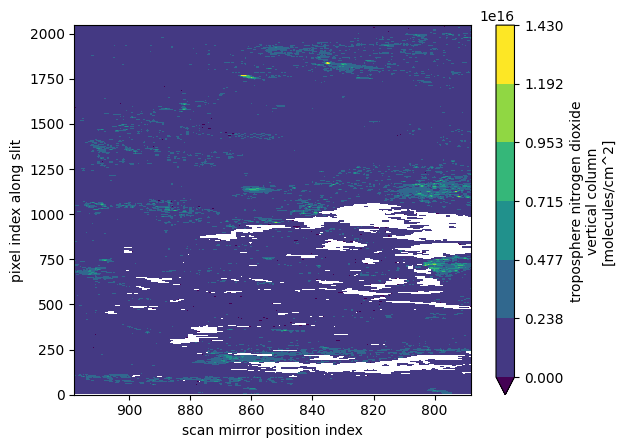

In [13]:
da.where(datatree["product/main_data_quality_flag"] == 0).plot.contourf(
    x="mirror_step", y="xtrack", vmin=0
)

plt.gca().invert_xaxis()
plt.show()

## 5. Retrieve only a single variable

In [36]:
# TEMPO Formaldehyde
request = Request(
    collection=Collection(id="C2930730944-LARC_CLOUD"),
    granule_name=["TEMPO_HCHO_L2_V03_20231230T145736Z_S003G08.nc"],
    variables=["product/vertical_column"],
)

job_id = harmony_client.submit(request)
print(f"jobID = {job_id}")
harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
results = harmony_client.download_all(job_id, directory="/tmp", overwrite=True)
all_results_stored = [f.result() for f in results]
print(f"Number of result files: {len(all_results_stored)}")

 [ Processing:   0% ] |                                                   | [/]

jobID = 698a9a2a-5f98-45d0-af2b-2868af7addfb


 [ Processing: 100% ] |###################################################| [|]


/kaggle/working/114674145_TEMPO_HCHO_L2_V03_20231230T145736Z_S003G08_product_vertical_column_subsetted.nc
Number of result files: 1


In [15]:
# Open the data file.
datatree = xr.open_datatree(all_results_stored[0])
datatree

<xarray.DataTree>
Group: /
│   Dimensions:      (xtrack: 2048, mirror_step: 131)
│   Coordinates:
│     * xtrack       (xtrack) int32 8kB 0 1 2 3 4 5 ... 2043 2044 2045 2046 2047
│     * mirror_step  (mirror_step) int32 524B 919 920 921 922 ... 1047 1048 1049
│   Attributes: (12/39)
│       tio_commit:                       040d27c76f5040d777912886b53b0f3a5cbb3e67
│       product_type:                     HCHO
│       processing_level:                 2
│       processing_version:               3
│       sdpc_version:                     TEMPO_SDPC_v4.4.2
│       scan_num:                         3
│       ...                               ...
│       collection_version:               1
│       keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>VO...
│       summary:                          Formaldehyde Level 2 files provide trac...
│       coremetadata:                     \nGROUP                  = INVENTORYMET...
│       history:                          2024-08-05T19:15:47Z:/tempo/nas0/sdpc_s...
│       history_json:                     [{"date_time": "2025-10-01T17:35:22.881...
├── Group: /product
│       Dimensions:          (mirror_step: 131, xtrack: 2048)
│       Data variables:
│           vertical_column  (mirror_step, xtrack) float64 2MB ...
├── Group: /geolocation
│       Dimensions:      (mirror_step: 131, xtrack: 2048)
│       Data variables:
│           time         (mirror_step) datetime64[ns] 1kB ...
│           latitude     (mirror_step, xtrack) float32 1MB ...
│           longitude    (mirror_step, xtrack) float32 1MB ...
├── Group: /support_data
└── Group: /qa_statistics
        Attributes: (12/13)
            num_bad_output:           117263
            num_converged:            160343
            num_crosstrack_pixels:    2048
            num_exceeded_iterations:  0
            num_failed_convergence:   0
            num_good_input:           268288
            ...                       ...
            num_out_of_bounds:        243
            num_scan_lines:           131
            num_suspect_output:       120624
            percent_bad_output:       43.707882
            percent_good_output:      11.33148
            percent_suspect_output:   44.96064

Note the reduced list of data variables.

## 6. Retrieve data from a select time range

In [16]:
# @title
# A clean-up step to ensure there isn't a clash between newly downloaded granules
for rf in all_results_stored:
    !rm {rf}

In [35]:
request = Request(
    collection=Collection(id="C2930730944-LARC_CLOUD"),
    # Note there is not a granule specified!
    temporal={
        "start": dt.datetime(2023, 12, 30, 22, 30, 0),
        "stop": dt.datetime(2023, 12, 30, 22, 45, 0),
    },
)

job_id = harmony_client.submit(request)

print(f"jobID = {job_id}")
harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
results = harmony_client.download_all(job_id, directory="/tmp", overwrite=True)
all_results_stored = [f.result() for f in results]
print(f"Number of result files: {len(all_results_stored)}")

 [ Processing:   0% ] |                                                   | [/]

jobID = 6960da42-b417-4370-a0b2-d313f2b25c6e


 [ Processing: 100% ] |###################################################| [|]


/kaggle/working/114673582_TEMPO_HCHO_L2_V03_20231230T222426Z_S010G03_subsetted.nc
/kaggle/working/114673583_TEMPO_HCHO_L2_V03_20231230T223104Z_S010G04_subsetted.nc
/kaggle/working/114673584_TEMPO_HCHO_L2_V03_20231230T223741Z_S010G05_subsetted.nc
/kaggle/working/114673585_TEMPO_HCHO_L2_V03_20231230T224418Z_S010G06_subsetted.nc
Number of result files: 4


In [18]:
# Open the data files
datatree_dict = dict()
for r in sorted(all_results_stored):
    datatree_dict[r] = xr.open_datatree(r)

    print(
        f"Time range: {datatree_dict[r]['geolocation/time'].values.min()} - "
        f"{datatree_dict[r]['geolocation/time'].values.max()}"
    )

Time range: 2023-12-30T22:30:00.279620864 - 2023-12-30T22:31:19.139312896
Time range: 2023-12-30T22:31:22.172382976 - 2023-12-30T22:37:56.470801152
Time range: 2023-12-30T22:37:59.503866880 - 2023-12-30T22:44:33.802316800
Time range: 2023-12-30T22:44:36.835376128 - 2023-12-30T22:44:58.066825984


Note how the time ranges fit within the requested temporal range

/usr/local/lib/python3.11/dist-packages/cartopy/crs.py:421: RuntimeWarning: invalid value encountered in greater
  to_180 = (x > 180) | (x < -180)
/usr/local/lib/python3.11/dist-packages/cartopy/crs.py:421: RuntimeWarning: invalid value encountered in less
  to_180 = (x > 180) | (x < -180)


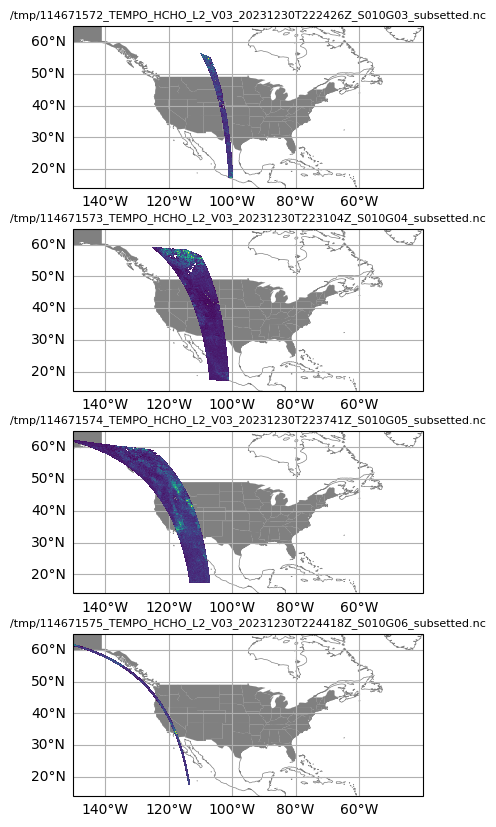

In [19]:
# Visualize each data file
fig, axs = plt.subplots(
    nrows=len(datatree_dict),
    sharex=True,
    figsize=(7, 10),
    gridspec_kw=dict(hspace=0.25),
    subplot_kw={"projection": data_proj},
)

for i, (key, tree) in enumerate(datatree_dict.items()):
    Var = tree["product/vertical_column"]

    if np.count_nonzero(~np.isnan(Var.values)) > 0:
        ax = axs[i]
        make_nice_map(ax)

        contour_handle = ax.contourf(
            tree["geolocation/longitude"],
            tree["geolocation/latitude"],
            Var,
            levels=100,
            vmin=0,
            zorder=2,
        )

        ax.set_title(key, fontsize=8)

plt.show()

In [20]:
# A clean-up step to ensure there isn't a clash between newly downloaded granules
for rf in all_results_stored:
    !rm {rf}

## 7. Retrieve data from a spatial bounding box

In [21]:
request = Request(
    collection=Collection(id="C2930730944-LARC_CLOUD"),
    # Note there is not a granule specified!
    spatial=BBox(-115, 35, -95, 45),
    temporal={
        "start": dt.datetime(2023, 12, 30, 22, 30, 0),
        "stop": dt.datetime(2023, 12, 30, 22, 45, 0),
    },
)

job_id = harmony_client.submit(request)

print(f"jobID = {job_id}")
harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
results = harmony_client.download_all(job_id, directory="/tmp", overwrite=True)
all_results_stored = [f.result() for f in results]
print(f"Number of result files: {len(all_results_stored)}")

 [ Processing:   0% ] |                                                   | [/]

jobID = dc16d987-eace-4592-a68a-008ee457681a


 [ Processing: 100% ] |###################################################| [|]


/tmp/114672018_TEMPO_HCHO_L2_V03_20231230T222426Z_S010G03_subsetted.nc
/tmp/114672020_TEMPO_HCHO_L2_V03_20231230T223741Z_S010G05_subsetted.nc
/tmp/114672019_TEMPO_HCHO_L2_V03_20231230T223104Z_S010G04_subsetted.nc
Number of result files: 3


In [22]:
# Open the data files
datatree_dict = dict()
for r in sorted(all_results_stored):
    datatree_dict[r] = xr.open_datatree(r)

/usr/local/lib/python3.11/dist-packages/cartopy/crs.py:421: RuntimeWarning: invalid value encountered in greater
  to_180 = (x > 180) | (x < -180)
/usr/local/lib/python3.11/dist-packages/cartopy/crs.py:421: RuntimeWarning: invalid value encountered in less
  to_180 = (x > 180) | (x < -180)
/usr/local/lib/python3.11/dist-packages/cartopy/crs.py:421: RuntimeWarning: invalid value encountered in greater
  to_180 = (x > 180) | (x < -180)
/usr/local/lib/python3.11/dist-packages/cartopy/crs.py:421: RuntimeWarning: invalid value encountered in less
  to_180 = (x > 180) | (x < -180)
/usr/local/lib/python3.11/dist-packages/cartopy/crs.py:421: RuntimeWarning: invalid value encountered in greater
  to_180 = (x > 180) | (x < -180)
/usr/local/lib/python3.11/dist-packages/cartopy/crs.py:421: RuntimeWarning: invalid value encountered in less
  to_180 = (x > 180) | (x < -180)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0

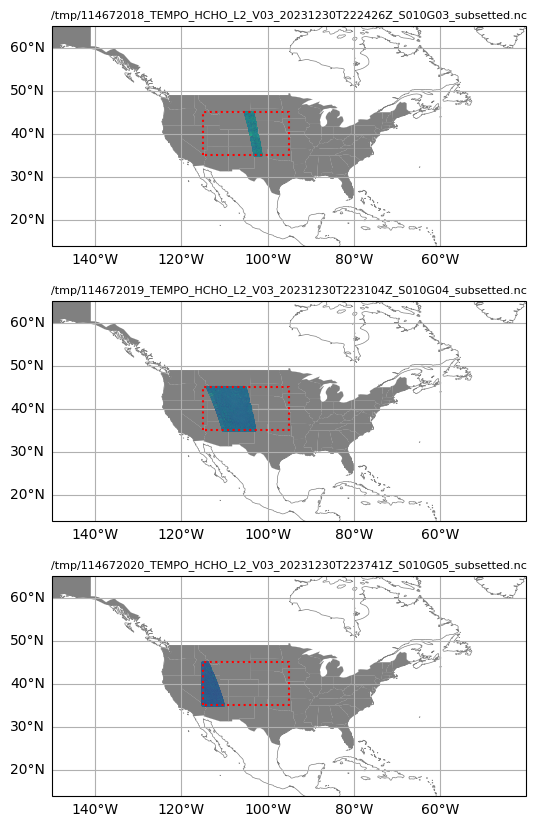

In [23]:
# Visualize each data file
fig, axs = plt.subplots(
    nrows=len(datatree_dict),
    sharex=True,
    figsize=(7, 10),
    gridspec_kw=dict(hspace=0.25),
    subplot_kw={"projection": data_proj},
)

for i, (key, tree) in enumerate(datatree_dict.items()):
    Var = tree["product/vertical_column"]
    ax = axs[i]
    if np.count_nonzero(~np.isnan(Var.values)) > 0:
        ax = axs[i]
        make_nice_map(ax)

        ax.scatter(
            tree["geolocation/longitude"], tree["geolocation/latitude"], s=1, c=Var, zorder=2
        )

        ax.set_title(key, fontsize=8)

        # Coordinates of rectangle vertices in clockwise order
        xs = [-115, -115, -95, -95, -115]
        ys = [35, 45, 45, 35, 35]
        ax.plot(xs, ys, color="red", linestyle=":")

plt.show()

Note the cut-off of data for the bounding box: (-115, 35, -95, 45)

End of Notebook.

In [24]:
# "Ozone3 total column"
request = Request(
    collection=Collection(id="C2930764281-LARC_CLOUD"),
    granule_name=["TEMPO_O3TOT_L3_V03_20250916T190309Z_S010.nc"],
)
request.is_valid()

True

In [25]:
job_id = harmony_client.submit(request)
print(f"jobID = {job_id}")

harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing:   0% ] |                                                   | [/]

jobID = a53c6e00-8790-4a31-a3fb-f6df9376b51a


 [ Processing: 100% ] |###################################################| [|]


In [26]:
results = harmony_client.download_all(job_id, directory="/tmp")
all_results_stored = [f.result() for f in results]

print(f"Number of result files: {len(all_results_stored)}")

/tmp/TEMPO_O3TOT_L3_V03_20250916T190309Z_S010.nc
Number of result files: 1


In [27]:
# Open the data file using the Xarray package.
#   Alternatively, one could use the
#   netCDF4-python (https://unidata.github.io/netcdf4-python/) library.
datatree = xr.open_datatree(all_results_stored[0])
datatree

<xarray.DataTree>
Group: /
│   Dimensions:    (longitude: 7750, latitude: 2950, time: 1)
│   Coordinates:
│     * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
│     * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
│     * time       (time) datetime64[ns] 8B 2025-09-16T19:03:27.010698496
│   Data variables:
│       weight     (latitude, longitude) float32 91MB ...
│   Attributes: (12/40)
│       history:                          2025-09-16T23:16:10Z: L2_regrid -v /tem...
│       scan_num:                         10
│       time_coverage_start:              2025-09-16T19:03:09Z
│       time_coverage_end:                2025-09-16T20:02:50Z
│       time_coverage_start_since_epoch:  1442084607.0106986
│       time_coverage_end_since_epoch:    1442088188.6339343
│       ...                               ...
│       title:                            TEMPO Level 3 total ozone product
│       collection_shortname:             TEMPO_O3TOT_L3
│       collection_version:               1
│       keywords:                         EARTH SCIENCE>ATMOSPHERE>ATMOSPHERIC CH...
│       summary:                          Total ozone Level 3 files provide ozone...
│       coremetadata:                     \nGROUP                  = INVENTORYMET...
├── Group: /product
│       Dimensions:               (time: 1, latitude: 2950, longitude: 7750)
│       Data variables:
│           column_amount_o3      (time, latitude, longitude) float32 91MB ...
│           radiative_cloud_frac  (time, latitude, longitude) float32 91MB ...
│           fc                    (time, latitude, longitude) float32 91MB ...
│           o3_below_cloud        (time, latitude, longitude) float32 91MB ...
│           so2_index             (time, latitude, longitude) float32 91MB ...
│           uv_aerosol_index      (time, latitude, longitude) float32 91MB ...
├── Group: /qa_statistics
│       Dimensions:             (time: 1, latitude: 2950, longitude: 7750)
│       Data variables:
│           num_column_samples  (time, latitude, longitude) float64 183MB ...
│           min_column_sample   (time, latitude, longitude) float32 91MB ...
│           max_column_sample   (time, latitude, longitude) float32 91MB ...
├── Group: /geolocation
│       Dimensions:                 (time: 1, latitude: 2950, longitude: 7750)
│       Data variables:
│           solar_zenith_angle      (time, latitude, longitude) float32 91MB ...
│           viewing_zenith_angle    (time, latitude, longitude) float32 91MB ...
│           relative_azimuth_angle  (time, latitude, longitude) float32 91MB ...
└── Group: /support_data
        Dimensions:           (time: 1, latitude: 2950, longitude: 7750)
        Data variables:
            cloud_pressure    (time, latitude, longitude) float32 91MB ...
            terrain_pressure  (time, latitude, longitude) float32 91MB ...
            terrain_height    (time, latitude, longitude) float32 91MB ...

In [28]:
product_variable_name = "product/o3_below_cloud"
da = datatree[product_variable_name]
da

<xarray.DataArray 'o3_below_cloud' (time: 1, latitude: 2950, longitude: 7750)> Size: 91MB
[22862500 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * time       (time) datetime64[ns] 8B 2025-09-16T19:03:27.010698496
Attributes:
    comment:    ozone below fractional cloud
    units:      DU
    valid_min:  0.0
    valid_max:  100.0

In [29]:
data_proj = ccrs.PlateCarree()


def make_nice_map(axis):
    axis.add_feature(cfeature.STATES, color="gray", lw=0.1)
    axis.coastlines(resolution="50m", color="gray", linewidth=0.5)

    axis.set_extent([-150, -40, 14, 65], crs=data_proj)
    grid = axis.gridlines(draw_labels=["left", "bottom"], dms=True)
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

In [30]:
print("Data array dimensions:", da.dims)
print("Data array shape:", da.shape)
print("Longitude shape:", datatree["geolocation/longitude"].shape)
print("Latitude shape:", datatree["geolocation/latitude"].shape)

Data array dimensions: ('time', 'latitude', 'longitude')
Data array shape: (1, 2950, 7750)
Longitude shape: (7750,)
Latitude shape: (2950,)


In [31]:
# 1. Check WHAT THE FUCK is this data (joking I don't swear (●'◡'●))
time_idx = 0
da_2d = da.isel(time=time_idx)
column_amount_o3_2d = datatree["product/o3_below_cloud"].isel(time=time_idx)

print("Data statistics:")
print(f"  Min: {da_2d.min().values}")
print(f"  Max: {da_2d.max().values}")
print(f"  Mean: {da_2d.mean().values}")
print(f"  Number of valid values: {(~da_2d.isnull()).sum().values}")
print(f"  Number of NaN values: {da_2d.isnull().sum().values}")

print("\ncolumn amount o3 statistics:")
print(f"  Unique values: {np.unique(column_amount_o3_2d.values)}")
print(f"  Number where so2_index == 0: {(column_amount_o3_2d == 0).sum().values}")

print("\nAfter masking:")
masked_data = da_2d.where(column_amount_o3_2d == 0)
print(f"  Number of valid values: {(~masked_data.isnull()).sum().values}")
print(f"  Min: {masked_data.min().values}")
print(f"  Max: {masked_data.max().values}")

Data statistics:
  Min: -1.5934131145477295
  Max: 36.3100700378418
  Mean: 4.493613243103027
  Number of valid values: 8396984
  Number of NaN values: 14465516

column amount o3 statistics:
  Unique values: [-1.5934131 -1.5933667 -1.591909  ... 36.260746  36.31007          nan]
  Number where so2_index == 0: 133843

After masking:
  Number of valid values: 133843
  Min: 0.0
  Max: 0.0


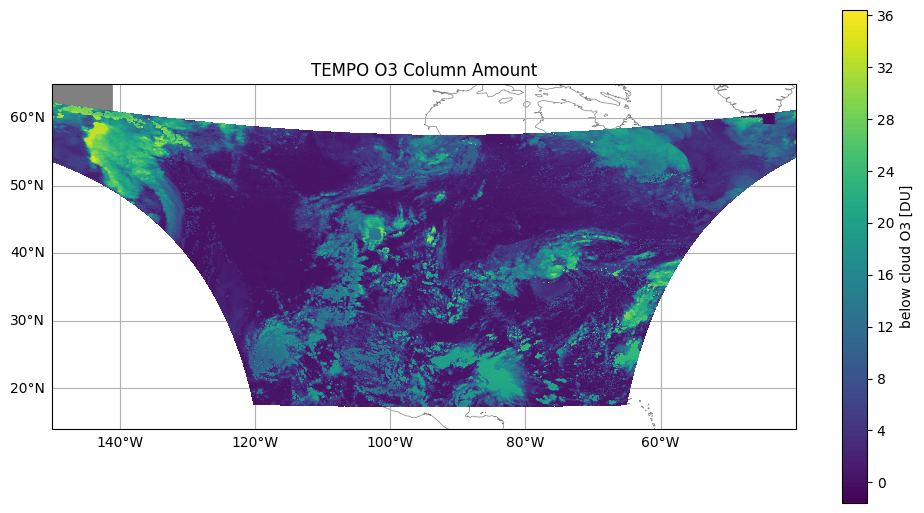

In [32]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": data_proj})
make_nice_map(ax)

time_idx = 0
da_2d = da.isel(time=time_idx)

# Plot without masking - show all valid O3 data
contour_handle = ax.contourf(
    datatree["geolocation/longitude"],
    datatree["geolocation/latitude"],
    da_2d,  
    levels=100,
    zorder=2,
)
cb = plt.colorbar(contour_handle, ax=ax, shrink=0.8)
cb.set_label('below cloud O3 [DU]')
ax.set_title(f'TEMPO O3 Column Amount')
plt.show()

## Making The Prediction Model with SKlearn

In [33]:
# Cell 1:Load Libraries
import numpy as np
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [59]:
# Cell 2: Load TEMPO Data
no2_dt = xr.open_datatree('/tmp/TEMPO_NO2_L2_V03_20250406T215103Z_S012G07.nc')
hcho_dt = xr.open_datatree('/kaggle/working/114674145_TEMPO_HCHO_L2_V03_20231230T145736Z_S003G08_product_vertical_column_subsetted.nc')
o3_dt = xr.open_datatree('/tmp/TEMPO_O3TOT_L3_V03_20250916T190309Z_S010.nc')

# Extract the data directly without time selection
no2_data = no2_dt["product/vertical_column_troposphere"].values
hcho_data = hcho_dt["product/vertical_column"].values
o3_data = o3_dt["product/o3_below_cloud"].values

print(f"NO2 shape: {no2_data.shape}")
print(f"HCHO shape: {hcho_data.shape}")
print(f"O3 shape: {o3_data.shape}")
print(f"O3 ndim: {o3_data.ndim}")

# If O3 has extra dimensions (like time), squeeze or select first
if o3_data.ndim > 2:
    print(f"O3 has extra dimensions, selecting first slice...")
    if o3_data.shape[0] == 1:
        o3_data = o3_data[0]  # Remove time dimension if it exists
    else:
        o3_data = o3_data[0]  # Take first time slice
    print(f"O3 shape after selection: {o3_data.shape}")

# Ensure all data are 2D arrays
no2_data = np.squeeze(no2_data)
hcho_data = np.squeeze(hcho_data)
o3_data = np.squeeze(o3_data)

print(f"\nFinal shapes:")
print(f"NO2: {no2_data.shape}, dtype: {no2_data.dtype}")
print(f"HCHO: {hcho_data.shape}, dtype: {hcho_data.dtype}")
print(f"O3: {o3_data.shape}, dtype: {o3_data.dtype}")
print(f"\nNO2 range: {np.nanmin(no2_data):.2e} to {np.nanmax(no2_data):.2e}")
print(f"HCHO range: {np.nanmin(hcho_data):.2e} to {np.nanmax(hcho_data):.2e}")
print(f"O3 range: {np.nanmin(o3_data):.2f} to {np.nanmax(o3_data):.2f}")


NO2 shape: (131, 2048)
HCHO shape: (131, 2048)
O3 shape: (1, 2950, 7750)
O3 ndim: 3
O3 has extra dimensions, selecting first slice...
O3 shape after selection: (2950, 7750)

Final shapes:
NO2: (131, 2048), dtype: float64
HCHO: (131, 2048), dtype: float64
O3: (2950, 7750), dtype: float32

NO2 range: -1.34e+16 to 1.43e+16
HCHO range: -2.99e+17 to 3.34e+17
O3 range: -1.59 to 36.31


In [60]:
# Cell 3: EPA AQI Calculation Functions (Official Breakpoints)
def calculate_aqi(concentration, breakpoints):
    """
    Calculate AQI using EPA formula with official breakpoints
    Formula: AQI = [(I_high - I_low) / (C_high - C_low)] * (C - C_low) + I_low
    """
    # Convert to scalar if it's an array
    if isinstance(concentration, np.ndarray):
        concentration = float(concentration)
    
    if np.isnan(concentration) or concentration < 0:
        return np.nan
    
    # Find the appropriate breakpoint range
    for bp_low, bp_high, aqi_low, aqi_high in breakpoints:
        if bp_low <= concentration <= bp_high:
            aqi = ((aqi_high - aqi_low) / (bp_high - bp_low)) * (concentration - bp_low) + aqi_low
            return int(round(aqi))
    
    # If concentration exceeds all breakpoints, return highest category
    return breakpoints[-1][3]

# EPA AQI Breakpoints for NO2 (ppb - 1-hour average)
# NO2 vertical column needs conversion: molecules/cm² to ppb
def no2_column_to_ppb(column_density):
    """Convert NO2 column density to approximate surface ppb"""
    # Simplified conversion for tropospheric NO2
    return column_density / 2e15  # Rough approximation

NO2_BREAKPOINTS = [
    # (Conc_low ppb, Conc_high ppb, AQI_low, AQI_high)
    (0, 53, 0, 50),          # Good
    (54, 100, 51, 100),      # Moderate
    (101, 360, 101, 150),    # Unhealthy for Sensitive
    (361, 649, 151, 200),    # Unhealthy
    (650, 1249, 201, 300),   # Very Unhealthy
    (1250, 2049, 301, 500),  # Hazardous
]

# EPA AQI Breakpoints for O3 (ppb - 8-hour average)
O3_BREAKPOINTS = [
    (0, 54, 0, 50),          # Good
    (55, 70, 51, 100),       # Moderate
    (71, 85, 101, 150),      # Unhealthy for Sensitive
    (86, 105, 151, 200),     # Unhealthy
    (106, 200, 201, 300),    # Very Unhealthy
]

# HCHO doesn't have official EPA AQI breakpoints
# Using approximate health-based thresholds
def hcho_column_to_ppb(column_density):
    """Convert HCHO column density to approximate ppb"""
    return column_density / 1e16  # Rough approximation

HCHO_BREAKPOINTS = [
    (0, 10, 0, 50),          # Good
    (11, 30, 51, 100),       # Moderate
    (31, 50, 101, 150),      # Unhealthy for Sensitive
    (51, 80, 151, 200),      # Unhealthy
    (81, 120, 201, 300),     # Very Unhealthy
]

def get_no2_aqi(no2_column):
    """Calculate AQI for NO2"""
    ppb = no2_column_to_ppb(no2_column)
    return calculate_aqi(ppb, NO2_BREAKPOINTS)

def get_o3_aqi(o3_ppb):
    """Calculate AQI for O3"""
    return calculate_aqi(o3_ppb, O3_BREAKPOINTS)

def get_hcho_aqi(hcho_column):
    """Calculate AQI for HCHO"""
    ppb = hcho_column_to_ppb(hcho_column)
    return calculate_aqi(ppb, HCHO_BREAKPOINTS)

def get_combined_aqi(no2_col, hcho_col, o3_ppb):
    """
    Get combined AQI - take the MAXIMUM (worst) pollutant AQI
    This follows EPA guidelines
    """
    aqis = []
    
    no2_aqi = get_no2_aqi(no2_col)
    if not np.isnan(no2_aqi):
        aqis.append(no2_aqi)
    
    hcho_aqi = get_hcho_aqi(hcho_col)
    if not np.isnan(hcho_aqi):
        aqis.append(hcho_aqi)
    
    o3_aqi = get_o3_aqi(o3_ppb)
    if not np.isnan(o3_aqi):
        aqis.append(o3_aqi)
    
    if len(aqis) == 0:
        return np.nan
    
    return max(aqis)  # Return worst AQI

def aqi_to_category(aqi):
    """Convert AQI value to category (0-5)"""
    if np.isnan(aqi):
        return np.nan
    if aqi <= 50:
        return 0  # Good
    elif aqi <= 100:
        return 1  # Moderate
    elif aqi <= 150:
        return 2  # Unhealthy for Sensitive
    elif aqi <= 200:
        return 3  # Unhealthy
    elif aqi <= 300:
        return 4  # Very Unhealthy
    else:
        return 5  # Hazardous


In [61]:
# Cell 4: Calculate Current AQI Map from Data
print("\nCalculating current AQI map from NO2, HCHO, and O3 data...")
current_aqi = np.full((no2_data.shape[0], no2_data.shape[1]), np.nan)
aqi_values = np.full((no2_data.shape[0], no2_data.shape[1]), np.nan)

for i in range(no2_data.shape[0]):
    for j in range(no2_data.shape[1]):
        # Extract scalar values using .item() to ensure single value
        try:
            no2_val = no2_data[i, j].item() if hasattr(no2_data[i, j], 'item') else float(no2_data[i, j])
            hcho_val = hcho_data[i, j].item() if hasattr(hcho_data[i, j], 'item') else float(hcho_data[i, j])
            o3_val = o3_data[i, j].item() if hasattr(o3_data[i, j], 'item') else float(o3_data[i, j])
        except (ValueError, TypeError):
            # If it's an array, take the first element
            no2_val = float(np.atleast_1d(no2_data[i, j]).flatten()[0])
            hcho_val = float(np.atleast_1d(hcho_data[i, j]).flatten()[0])
            o3_val = float(np.atleast_1d(o3_data[i, j]).flatten()[0])
        
        aqi = get_combined_aqi(no2_val, hcho_val, o3_val)
        aqi_values[i, j] = aqi
        current_aqi[i, j] = aqi_to_category(aqi)

categories = ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
print("\nCurrent Air Quality Distribution:")
for i, cat in enumerate(categories):
    count = np.sum(current_aqi == i)
    total = np.sum(~np.isnan(current_aqi))
    percentage = (count / total) * 100 if total > 0 else 0
    print(f"  {cat}: {count} pixels ({percentage:.1f}%)")

print(f"\nAverage AQI: {np.nanmean(aqi_values):.1f}")
print(f"Max AQI: {np.nanmax(aqi_values):.1f}")
print(f"Min AQI: {np.nanmin(aqi_values):.1f}")



Calculating current AQI map from NO2, HCHO, and O3 data...

Current Air Quality Distribution:
  Good: 210283 pixels (99.7%)
  Moderate: 484 pixels (0.2%)
  Unhealthy for Sensitive: 6 pixels (0.0%)
  Unhealthy: 0 pixels (0.0%)
  Very Unhealthy: 140 pixels (0.1%)
  Hazardous: 0 pixels (0.0%)

Average AQI: 3.0
Max AQI: 300.0
Min AQI: 0.0
